In [1]:
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 62.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import string
from underthesea import word_tokenize
from typing import List, Dict, Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset


In [3]:
X_train = pd.read_csv('/content/drive/MyDrive/NLP/lab2 data/train/sents.txt', sep='/n', header=None, index_col=None)
X_test = pd.read_csv('/content/drive/MyDrive/NLP/lab2 data/test/sents.txt', sep='/n', header=None, index_col=None)
X_dev = pd.read_csv('/content/drive/MyDrive/NLP/lab2 data/dev/sents.txt', sep='/n', header=None, index_col=None)
y_train = pd.read_csv('/content/drive/MyDrive/NLP/lab2 data/train/sentiments.txt', sep='/n', header=None, index_col=None)
y_test = pd.read_csv('/content/drive/MyDrive/NLP/lab2 data/test/sentiments.txt', sep='/n', header=None, index_col=None)
y_dev = pd.read_csv('/content/drive/MyDrive/NLP/lab2 data/dev/sentiments.txt', sep='/n', header=None, index_col=None)

<ipython-input-3-19192424adb8>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  X_train = pd.read_csv('/content/drive/MyDrive/NLP/lab2 data/train/sents.txt', sep='/n', header=None, index_col=None)
<ipython-input-3-19192424adb8>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  X_test = pd.read_csv('/content/drive/MyDrive/NLP/lab2 data/test/sents.txt', sep='/n', header=None, index_col=None)
<ipython-input-3-19192424adb8>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you

In [4]:
# tao dataframe cua tap train và test
columns = ['sentence', 'label']
df_train = pd.concat([X_train, y_train], axis = 1)
df_train.columns = columns
df_test = pd.concat([X_test, y_test], axis = 1)
df_test.columns = columns

In [5]:
import re
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)
def clean_text(text) -> str:
    text = text.lower()
    text = re.sub(emoji_pattern, " ", text)  # remove emojis

    text = re.sub(r'([a-z]+?)\1+', r'\1', text)  # reduce repeated character (e.g. 'aaabbb' -> 'ab')

    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)

    text = text.strip()
    while text.endswith(tuple(string.punctuation + string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation + string.whitespace)):
        text = text[1:]

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r"\s+", " ", text)

    # Convert the tokenized text to string
    text = " ".join(word_tokenize(text))

    return text
def tokenize_word(text):
  return word_tokenize(clean_text(text), format="text")

In [6]:
## create dictionary
dictionary = {'unk': 0, 'pad' : 1}
d = 2
for dong in X_train.values:
  for chu in tokenize_word(dong[0]).split():
    if chu not in dictionary.keys():
      dictionary[chu] = d
      d = d+1

In [7]:
def convert2int(sentence):
  sen = []
  for chu in tokenize_word(sentence).split():
    if chu not in dictionary.keys():
      sen.append(0)
    else:
      sen.append(dictionary[chu])
  return sen

In [8]:
def add_padding(sentence):
  if len(sentence) < 109:
    sentence = sentence + [1] * (109 - len(sentence))
  return sentence

In [9]:
## convert to int
df_train['encode'] = df_train.apply(lambda x: convert2int(x.sentence), axis = 1)
df_test['encode'] = df_test.apply(lambda x: convert2int(x.sentence), axis = 1)

In [10]:
## add padding
df_train['padding'] = df_train.apply(lambda x: add_padding(x.encode), axis = 1)
df_test['padding'] = df_test.apply(lambda x: add_padding(x.encode), axis = 1)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    texts, labels = zip(*batch)
    # Convert text sequences to tensors and pad them
    text_tensors = pad_sequence([torch.tensor(text) for text in texts], padding_value=1)
    label_tensors = torch.tensor(labels)
    return text_tensors, label_tensors

In [13]:
class ListDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Trả về mẫu và nhãn tương ứng ở vị trí index
        return torch.tensor(self.data[index]), torch.tensor(self.labels[index])

In [14]:
my_traindata = ListDataset(df_train.padding, df_train.label)
my_testdata = ListDataset(df_test.padding, df_test.label)

In [15]:
train_dataloader = DataLoader(my_traindata, batch_size=16, shuffle=True)
test_dataloader = DataLoader(my_testdata, batch_size=16, shuffle=False)

In [16]:
t, l = next(iter(train_dataloader))

In [17]:
len(t)

16

In [18]:
l

tensor([0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2])

## Bai 1
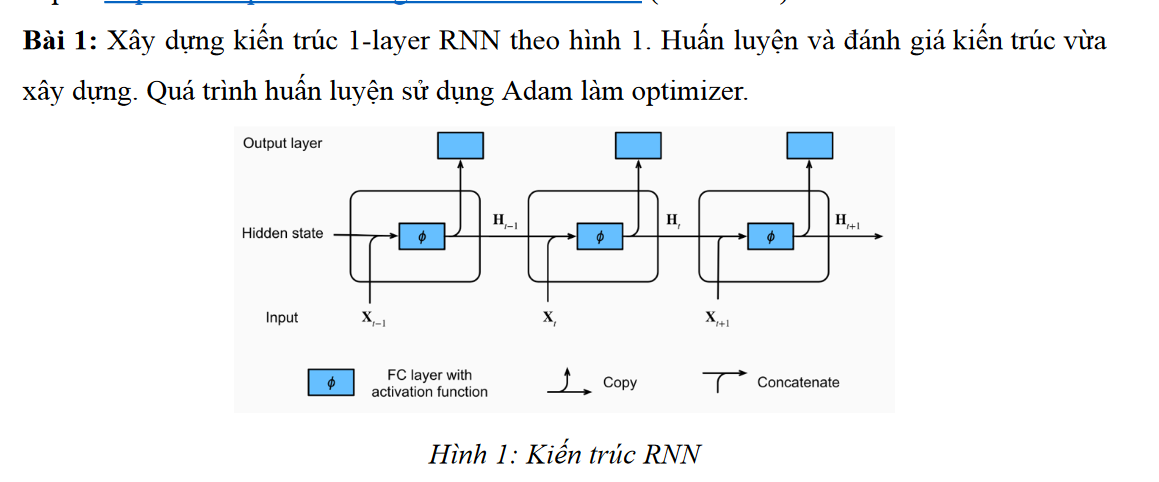

In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim = 300, padding_idx=1)
    self.rnn = nn.RNN(300, hidden_size, batch_first = True)
    self.fc =  nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = self.embedding(x)
    output, h_n = self.rnn(x)
    output = self.fc(output[:, -1, :])
    return output

In [ ]:
import torch.optim as optim


model = RNN(len(dictionary) + 1, 16, 256,3)
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [25]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
model.train()
for epoch in range(5):
  train_loss = 0
  for text, label in train_dataloader:
    optimizer.zero_grad()
    pred = model(text).argmax(dim = 1)
    loss = criterion(pred.float(), label.float())
    train_loss += loss
    loss.requires_grad = True
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for text, label in test_dataloader:
      y_pred = model(text).argmax(dim = 1)
      test_loss += criterion(y_pred.float(), label.float())
      test_acc += accuracy_fn(y_true=label, y_pred=y_pred)
    test_acc /= len(test_dataloader)
print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


Train loss: 45.53670 | Test loss: 9278.38086, Test acc: 44.51%



## Bai 2
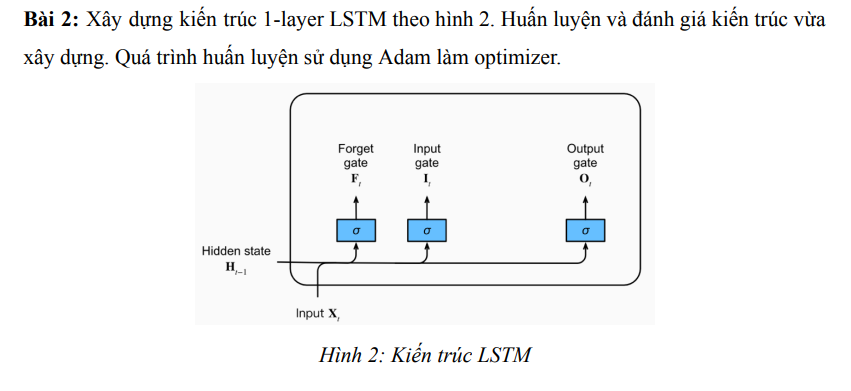

In [19]:
class LSTM(nn.Module):
  def __init__(self, vocab_size, input_size, hidden_size, output_size):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim = 300, padding_idx=1)
    self.lstm = nn.LSTM(300, hidden_size, batch_first = True)
    self.fc =  nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(0.2)
  def forward(self, x):
    emb = self.embedding(x)
    output = self.dropout(emb)
    packed_output,(hidden_state,cell_state) = self.lstm(output)
    return self.fc(hidden_state[-1])

In [20]:
import torch.optim as optim

model = LSTM(len(dictionary) + 1, 16, 256,3)
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [21]:
model

LSTM(
  (embedding): Embedding(4076, 300, padding_idx=1)
  (lstm): LSTM(300, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
model.train()
for epoch in range(5):
  train_loss = 0
  for text, label in train_dataloader:
    optimizer.zero_grad()
    pred = model(text)
    loss = criterion(pred, label.long())
    train_loss += loss
    loss.backward()
    optimizer.step()
train_loss /= len(train_dataloader)
test_loss, test_acc = 0, 0


In [26]:
model.eval()
with torch.inference_mode():
  for text, label in test_dataloader:
      y_pred = model(text).argmax(dim = 1)
      test_loss += criterion(y_pred.float(), label.float())
      test_acc += accuracy_fn(y_true=label, y_pred=y_pred)
  test_acc /= len(test_dataloader)
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


Train loss: 0.83476 | Test loss: 9350.46875, Test acc: 44.51%



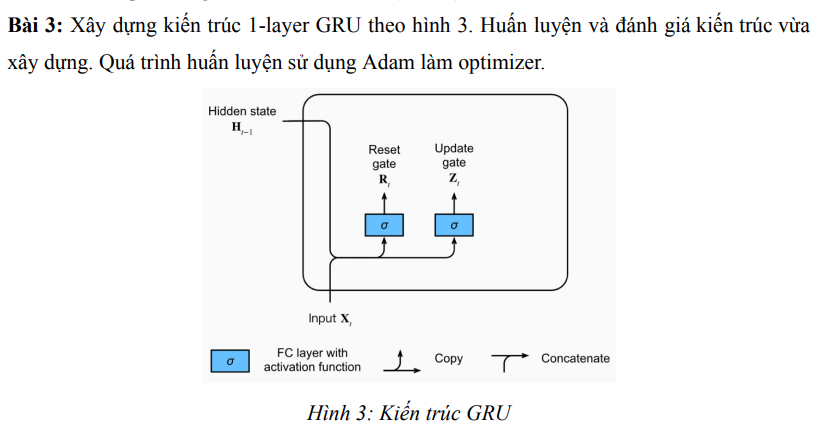

In [27]:
class GRU(nn.Module):
  def __init__(self, vocab_size, input_size, hidden_size, output_size):
    super(GRU, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim = 300, padding_idx=1)
    self.gru = nn.GRU(300, hidden_size, batch_first = True)
    self.fc =  nn.Linear(hidden_size, output_size)
  def forward(self, x):
    emb = self.embedding(x)
    out, _ = self.gru(emb)
    return self.fc(out[:,-1,:])

In [28]:
model = GRU(len(dictionary) + 1, 16, 256,3)
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [29]:
model.train()
for epoch in range(5):
  train_loss = 0
  for text, label in train_dataloader:
    optimizer.zero_grad()
    pred = model(text)
    loss = criterion(pred, label.long())
    train_loss += loss
    loss.backward()
    optimizer.step()
train_loss /= len(train_dataloader)
test_loss, test_acc = 0, 0


In [30]:
model.eval()
with torch.inference_mode():
  for text, label in test_dataloader:
      y_pred = model(text).argmax(dim = 1)
      test_loss += criterion(y_pred.float(), label.float())
      test_acc += accuracy_fn(y_true=label, y_pred=y_pred)
  test_acc /= len(test_dataloader)
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


Train loss: 0.24798 | Test loss: 8212.20703, Test acc: 88.25%

